In [2]:
# torch
import torch
from torch import nn

# torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# visualization
import matplotlib.pyplot as plt

# accuracy metric
from torchmetrics import Accuracy

# tqdm
from tqdm import tqdm

# check pytorch and torchvision versions
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cpu
0.15.1+cpu


In [2]:
# setup training data
train_data = datasets.FashionMNIST(
            root = "data",  # directory to download data to
            train = True,  # get training data
            download = True, # download data if it does not exist on disk
            transform = ToTensor(), #images would be in PIL format, convert them to tensor
            target_transform = None # labels can be transformed too
        )

# setup testing data
test_data = datasets.FashionMNIST(
            root = "data",
            train = False, 
            download = True,
            transform = ToTensor()
        )

In [3]:
# check first training sample from downloaded data
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [4]:
# shape of the image 
image.shape

torch.Size([1, 28, 28])

In [5]:
# check train/test size 
print(f"training data :", len(train_data.data))
print(f"training target :", len(train_data.targets))
print(f"testing data :", len(test_data.data))
print(f"testing target :", len(test_data.targets))

training data : 60000
training target : 60000
testing data : 10000
testing target : 10000


In [6]:
# classes/labels in target
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# this is to keeping the kernel alive
# https://stackoverflow.com/questions/64216189/kernel-keeps-dying-when-plotting-a-graph-after-importing-the-torch-library
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

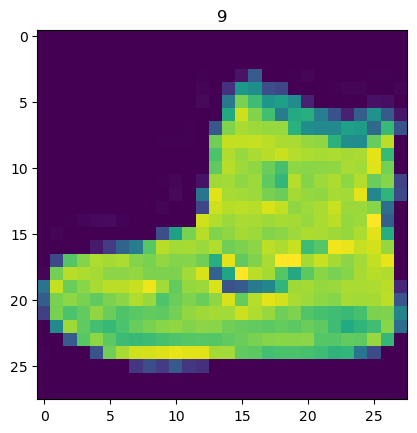

In [8]:
# visualize the image
plt.imshow(image.squeeze())
plt.title(label);

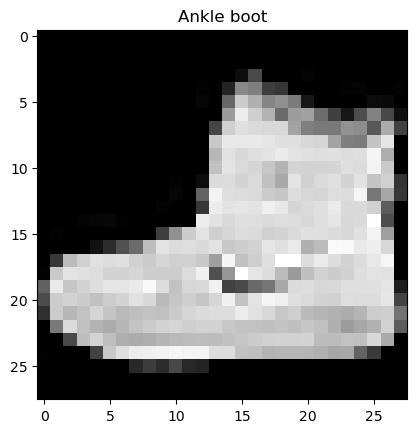

In [10]:
# show grayscale image
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label]);

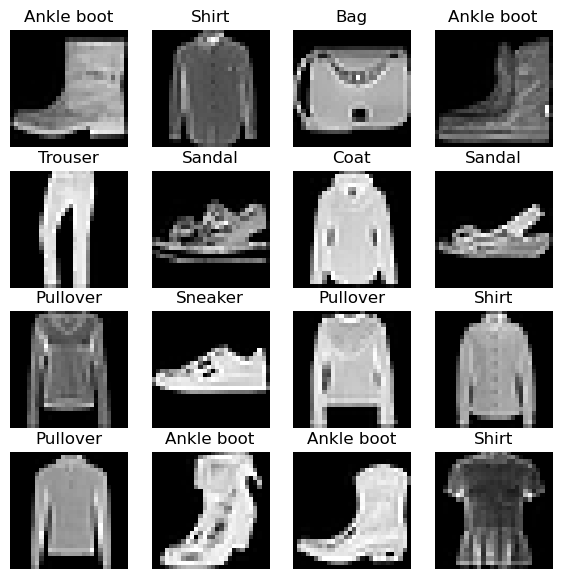

In [12]:
# plot few more images to inspect the data we are dealing with
torch.manual_seed(42)
fig = plt.figure(figsize=(7, 7))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False);

In [7]:
from torch.utils.data import DataLoader

# batchsize hyperparameter
BATCH_SIZE = 32

# turn dataset into mini chunks/ batches
train_dataloader = DataLoader(train_data, # datasets to choose batches from
                            batch_size = BATCH_SIZE,
                            shuffle = True # shuffle data at every epoch
                             )

test_dataloader = DataLoader(test_data,
                            batch_size = BATCH_SIZE,
                            shuffle=False # test data shuffle is not necessary
                            )

print(f"length of train data loader {len(train_dataloader)} with batch size: {BATCH_SIZE}")
print(f"length of test data loader {len(test_dataloader)} with batch size: {BATCH_SIZE}")

length of train data loader 1875 with batch size: 32
length of test data loader 313 with batch size: 32


In [8]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [9]:
# create a flatten layer
flatten_model = nn.Flatten()

# try with a single sample
x = train_features_batch[0]
output = flatten_model(x)

print(x.shape)
print(output.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [13]:
# build a baseline model

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), # nonlinear activation function
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784,
                             hidden_units=10,
                             output_shape=len(class_names)
                             )
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [16]:
# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
accuracy_fn = Accuracy(task = 'multiclass', num_classes=len(class_names))

In [4]:
# training and testing loops
def train_step(model: nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              ):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):       
        # forward pass
        y_pred = model(X)
        
        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(target = y, preds=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        # loss backward
        loss.backward()
        
        # optimizer step
        optimizer.step() 
        
    # cal loss and acc per epoch and print
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print("training loss :", train_loss)
    print("training acc :", train_acc)

def test_step(data_loader: DataLoader,
              model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(target=y, preds=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print("testing loss :", test_loss)
        print("testing acc :", test_acc)

Writing traintest.py


In [46]:
torch.manual_seed(42)
epochs =3
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n---------------")
    train_step(data_loader=train_dataloader,
              model= model_0,
              loss_fn= loss_fn,
              optimizer=optimizer,
              accuracy_fn = accuracy_fn)
    test_step(data_loader=test_dataloader,
             model= model_0,
              loss_fn = loss_fn,
             accuracy_fn=accuracy_fn)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch : 0
---------------
training loss : tensor(0.4307, grad_fn=<DivBackward0>)
training acc : tensor(0.8492)


 33%|████████████████████████████                                                        | 1/3 [00:13<00:26, 13.09s/it]

testing loss : tensor(0.4599)
testing acc : tensor(0.8384)
Epoch : 1
---------------
training loss : tensor(0.4271, grad_fn=<DivBackward0>)
training acc : tensor(0.8509)


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:27<00:13, 13.58s/it]

testing loss : tensor(0.4611)
testing acc : tensor(0.8407)
Epoch : 2
---------------
training loss : tensor(0.4227, grad_fn=<DivBackward0>)
training acc : tensor(0.8514)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:41<00:00, 13.75s/it]

testing loss : tensor(0.4633)
testing acc : tensor(0.8395)


In [17]:
# model evaluation
def eval_model(model: nn.Module, 
               data_loader: DataLoader, 
               loss_fn: nn.Module, 
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(target=y, 
                                preds=y_pred.argmax(dim=1)) 
        
        # average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [48]:
model_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4633435010910034,
 'model_acc': tensor(0.8395)}

In [52]:
# pre_trained models in pytorch
from torchvision import models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [31]:
# let us now build a CNN model
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3, # how big is the square that's going over the image
                     stride=1, # default
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride is same as kernel_size
        )
        self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                     out_features=output_shape))
        
    def forward(self, x:torch.tensor):
        x = self.block_1(x)
#         print(x.shape, "shape of x after block1")
        x = self.block_2(x)
#         print(x.shape, "shape of x after block2")
        x = self.classifier(x)
#         print(x.shape, "shape of x after classifier")
        return x
    
torch.manual_seed(42)
model_1 = FashionMNISTModelV2(input_shape=1, 
                              hidden_units=10, 
                              output_shape=len(class_names))
model_1           

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [32]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr = 0.1)

In [33]:
torch.manual_seed(42)
epochs =3
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n---------------")
    train_step(data_loader=train_dataloader,
              model= model_1,
              loss_fn= loss_fn,
              optimizer=optimizer,
              accuracy_fn = accuracy_fn)
    test_step(data_loader=test_dataloader,
             model= model_1,
              loss_fn = loss_fn,
             accuracy_fn=accuracy_fn)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch : 0
---------------
training loss : tensor(0.5879, grad_fn=<DivBackward0>)
training acc : tensor(0.7863)


 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.13s/it]

testing loss : tensor(0.4157)
testing acc : tensor(0.8540)
Epoch : 1
---------------
training loss : tensor(0.3644, grad_fn=<DivBackward0>)
training acc : tensor(0.8677)


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:40, 40.21s/it]

testing loss : tensor(0.3460)
testing acc : tensor(0.8715)
Epoch : 2
---------------
training loss : tensor(0.3257, grad_fn=<DivBackward0>)
training acc : tensor(0.8814)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.96s/it]

testing loss : tensor(0.3238)
testing acc : tensor(0.8813)


In [34]:
# Get model_2 results 
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_1_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3237966001033783,
 'model_acc': tensor(0.8813)}

In [35]:
# predictions 
def predictions(model: nn.Module, data: list):
    pred_probs= []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            pred_logit = model(sample) # forward pass model outputs raw logit
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)

In [39]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [44]:
pred_probs= predictions(model=model_1, data=test_samples)

# View first two prediction probabilities list
print(pred_probs[:2])

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)

tensor([[4.9363e-08, 2.5553e-08, 3.0727e-08, 3.4998e-08, 1.3982e-08, 9.9976e-01,
         1.6999e-07, 1.3213e-06, 7.3708e-06, 2.2877e-04],
        [2.2799e-02, 8.2202e-01, 9.7039e-04, 6.2166e-02, 2.8598e-02, 1.5598e-05,
         6.2822e-02, 9.1064e-05, 3.2060e-04, 1.9457e-04]])
tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])


In [46]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

In [ ]:
# this is to keeping the kernel alive
# https://stackoverflow.com/questions/64216189/kernel-keeps-dying-when-plotting-a-graph-after-importing-the-torch-library
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]
    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 
    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}" 
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);